In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [49]:
df =pd.read_csv("../data/household_power_consumption.txt",sep=';',low_memory=False)

In [50]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [51]:
print("Initial DataFrame Info:")
df.info()

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# ---  Data Cleaning and Transformation ---

In [52]:
# Combine Date and Time and set as index
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

In [53]:
# Convert all columns to numeric, coercing errors
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [54]:
# Handle missing timestamps by resampling to a regular frequency (1 minute)
# This will fill in any missing rows with NaN
df_regular = df.resample('min').mean()

In [55]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [56]:

# Handle missing values using linear interpolation
df_regular.interpolate(method='time', inplace=True)

In [57]:
# Check null values in the resampled dataframe
df_regular.isnull().sum()


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

--- Outlier Detection and Treatment ---

In [ ]:
from scipy import stats

print("\ Outlier Detection and Treatment")

# Z-score method for outlier detection
z_scores = np.abs(stats.zscore(df_regular['Global_active_power']))
threshold = 3  # common cutoff
outliers = df_regular[z_scores > threshold]

print(f"Detected {len(outliers)} outliers in Global_active_power")




Step 2.1: Outlier Detection and Treatment
Detected 36671 outliers in Global_active_power


In [59]:
#  Replace outliers with median
df_regular['Global_active_power_cleaned'] = df_regular['Global_active_power']
median_value = df_regular['Global_active_power'].median()
df_regular.loc[z_scores > threshold, 'Global_active_power_cleaned'] = median_value

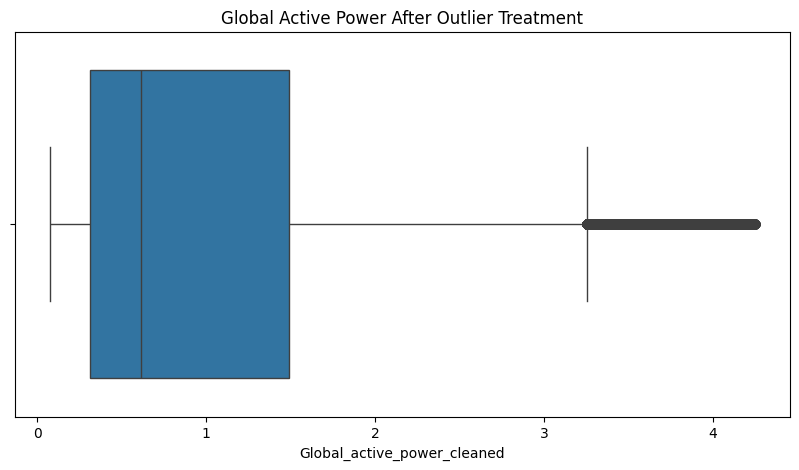

In [60]:
# Quick visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_regular['Global_active_power_cleaned'])
plt.title("Global Active Power After Outlier Treatment")
plt.show()


--- Feature Engineering ---

In [61]:
# add time-based features like hour and day of week
df_regular['hour'] = df_regular.index.hour
df_regular['day_of_week'] = df_regular.index.dayofweek

In [62]:
print("\nCleaned and Transformed DataFrame Info:")
df_regular.info()


Cleaned and Transformed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Freq: min
Data columns (total 10 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Global_active_power          float64
 1   Global_reactive_power        float64
 2   Voltage                      float64
 3   Global_intensity             float64
 4   Sub_metering_1               float64
 5   Sub_metering_2               float64
 6   Sub_metering_3               float64
 7   Global_active_power_cleaned  float64
 8   hour                         int32  
 9   day_of_week                  int32  
dtypes: float64(8), int32(2)
memory usage: 158.3 MB


In [63]:
print("\nFirst 5 rows of the transformed data:")
print(df_regular.head())



First 5 rows of the transformed data:
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0          

 ---  Exploratory Data Analysis (EDA) ---

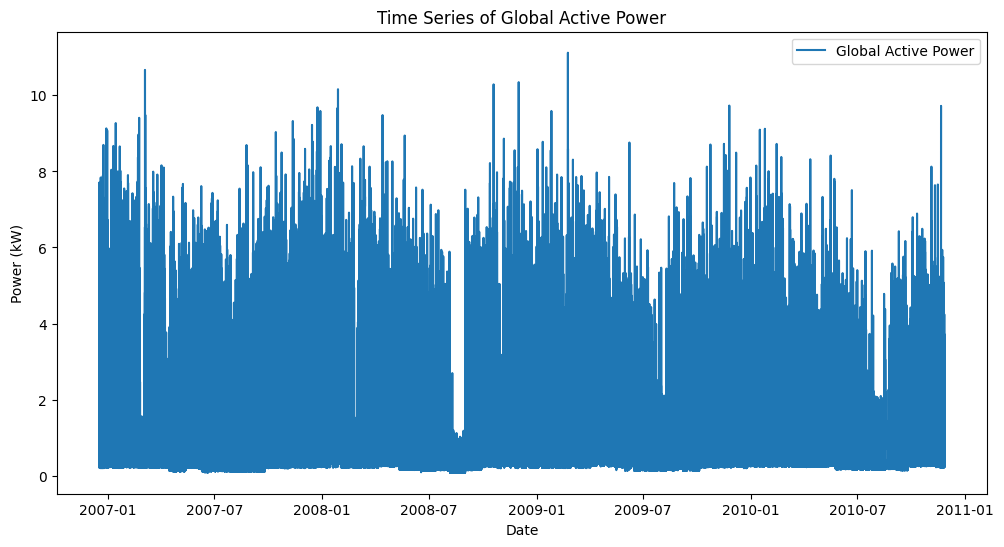

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(df_regular['Global_active_power'], label='Global Active Power')
plt.title('Time Series of Global Active Power')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [65]:
# Resample to hourly for a clearer trend visualization
hourly_data = df_regular['Global_active_power'].resample('h').mean().dropna()

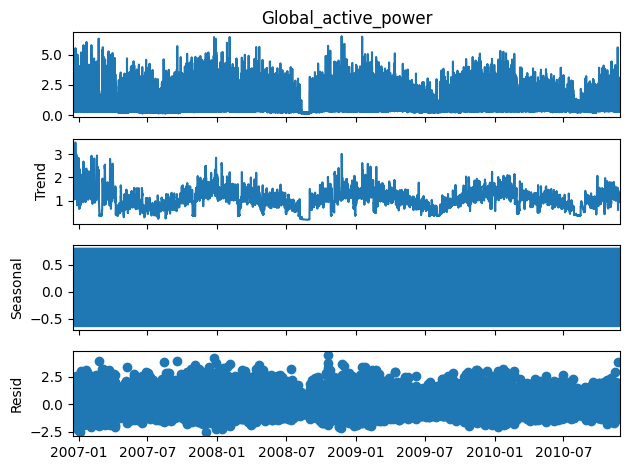

In [77]:
# Decompose the time series to see trend, seasonality, and residuals
decomposition = seasonal_decompose(hourly_data, model='additive')
fig = decomposition.plot()
plt.show()


 Statistical Analysis
ADF Statistic: -14.371344689221454
p-value: 9.482687472634345e-27
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
The series is likely stationary (reject H0).


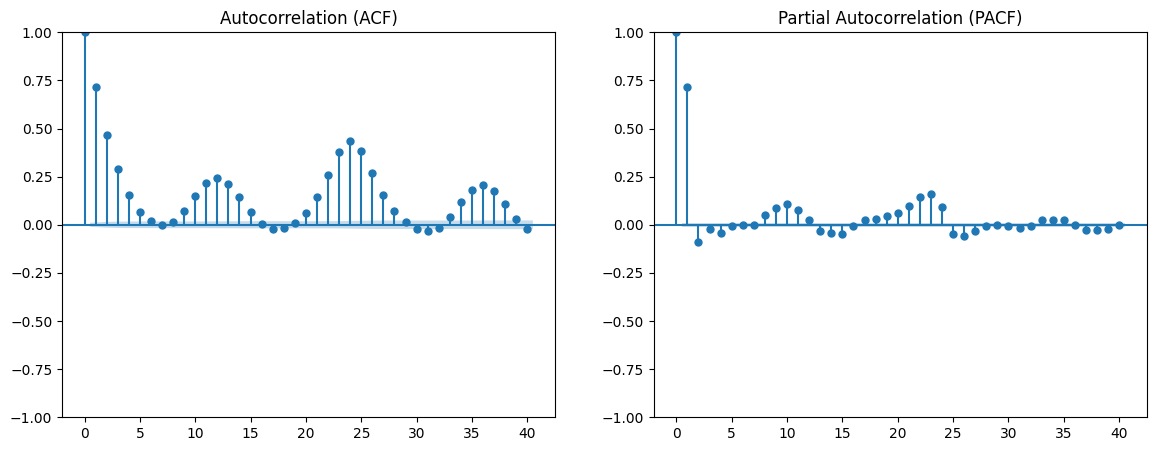


Key Findings:
- If ADF p-value > 0.05 → series is non-stationary (differencing may be required).
- ACF shows correlation at lag k → suggests MA(q) component.
- PACF shows cutoff at lag p → suggests AR(p) component.
- Together, ACF & PACF guide ARIMA(p,d,q) parameter selection.


In [79]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

print("\n Statistical Analysis")

# Augmented Dickey-Fuller Test (Stationarity) ---
result = adfuller(y.dropna()) 

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if result[1] <= 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print(" The series is likely non-stationary (fail to reject H0).")

#  ACF and PACF plots ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(y.dropna(), lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(y.dropna(), lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.show()


print("\nKey Findings:")
print("- If ADF p-value > 0.05 → series is non-stationary (differencing may be required).")
print("- ACF shows correlation at lag k → suggests MA(q) component.")
print("- PACF shows cutoff at lag p → suggests AR(p) component.")
print("- Together, ACF & PACF guide ARIMA(p,d,q) parameter selection.")


 --- Model Development ---

In [68]:
y = hourly_data

In [69]:
# Split data into training and validation sets (80/20 split)
train_size = int(len(y) * 0.8)
train_data, val_data = y[:train_size], y[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Training data size: 27671
Validation data size: 6918


In [70]:
# Model Selection (ARIMA) and Training
# We use a simple (1,1,1) order for demonstration purposes.
# In a real project, you would determine this using ACF/PACF plots or auto-ARIMA.
try:
    model = ARIMA(train_data, order=(0, 1, 1))
    fitted_model = model.fit()
    print("\nARIMA model training complete.")
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    fitted_model = None


ARIMA model training complete.


 ---  Model Evaluation and Optimization ---

In [71]:
if fitted_model:
    predictions = fitted_model.forecast(steps=len(val_data))
    predictions.index = val_data.index  

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(val_data, predictions))
    mae = mean_absolute_error(val_data, predictions)

    print("\nModel Performance on Validation Set:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")



Model Performance on Validation Set:
Root Mean Squared Error (RMSE): 0.9736
Mean Absolute Error (MAE): 0.6662


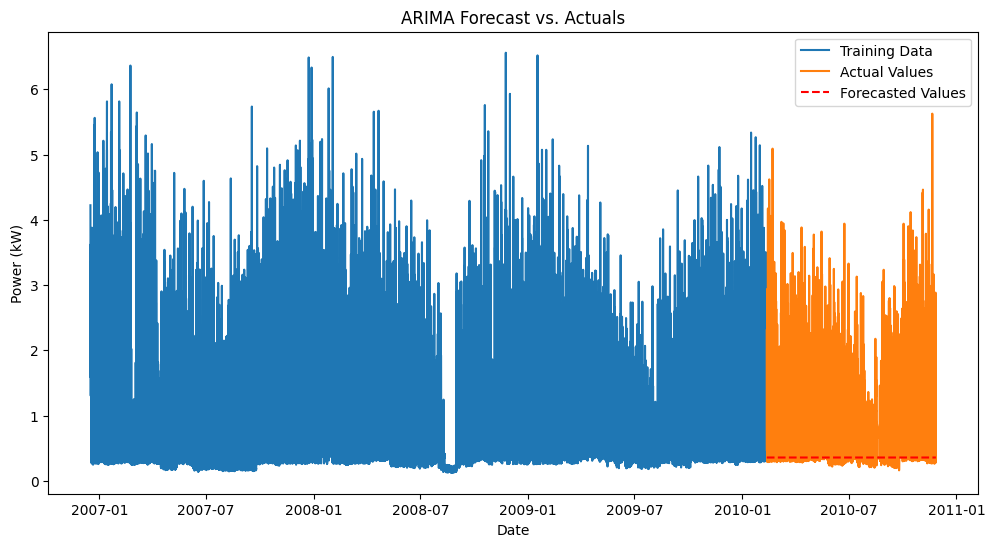

In [72]:
    # Plotting the forecast against actual values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(val_data.index, val_data, label='Actual Values')
    plt.plot(predictions.index, predictions, color='red', linestyle='--', label='Forecasted Values')
    plt.title('ARIMA Forecast vs. Actuals')
    plt.xlabel('Date')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.show()

--- Parameter Tuning (Grid Search for ARIMA) ---

In [76]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

print("\n Parameter Tuning (Grid Search)")

# Define parameter ranges
p = d = q = range(0, 3)  # can expand to (0, 4) or higher
pdq = list(itertools.product(p, d, q))

best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        fitted = model.fit()
        preds = fitted.forecast(steps=len(val_data))
        rmse = np.sqrt(mean_squared_error(val_data, preds))
        
        if rmse < best_score:
            best_score, best_cfg = rmse, param
        
        print(f"ARIMA{param} RMSE={rmse:.4f}")
    except:
        continue

print(f" Best ARIMA order: {best_cfg} with RMSE={best_score:.4f}")



 Parameter Tuning (Grid Search)
ARIMA(0, 0, 0) RMSE=0.7364
ARIMA(0, 0, 1) RMSE=0.7364
ARIMA(0, 0, 2) RMSE=0.7364
ARIMA(0, 1, 0) RMSE=0.9736
ARIMA(0, 1, 1) RMSE=0.9736
ARIMA(0, 1, 2) RMSE=0.8410
ARIMA(0, 2, 0) RMSE=204.6418
ARIMA(0, 2, 1) RMSE=1.2993
ARIMA(0, 2, 2) RMSE=1.3569
ARIMA(1, 0, 0) RMSE=0.7364
ARIMA(1, 0, 1) RMSE=0.7364
ARIMA(1, 0, 2) RMSE=0.7364
ARIMA(1, 1, 0) RMSE=0.9756


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) RMSE=0.8843
ARIMA(1, 1, 2) RMSE=0.8837
ARIMA(1, 2, 0) RMSE=586.3946
ARIMA(1, 2, 1) RMSE=1.3249
ARIMA(1, 2, 2) RMSE=1.3779
ARIMA(2, 0, 0) RMSE=0.7364
ARIMA(2, 0, 1) RMSE=0.7364
ARIMA(2, 0, 2) RMSE=0.7364
ARIMA(2, 1, 0) RMSE=0.9409
ARIMA(2, 1, 1) RMSE=0.8830


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) RMSE=0.8665
ARIMA(2, 2, 0) RMSE=1136.4338
ARIMA(2, 2, 1) RMSE=1.2977


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) RMSE=61857039534.4025
 Best ARIMA order: (0, 0, 2) with RMSE=0.7364


In [75]:
from sklearn.model_selection import TimeSeriesSplit

print("\n Cross-Validation")

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(y), 1):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    model = ARIMA(train, order=(0, 0, 2))  
    fitted = model.fit()
    preds = fitted.forecast(steps=len(test))
    
    rmse = np.sqrt(mean_squared_error(test, preds))
    rmse_scores.append(rmse)
    
    print(f"Fold {fold}: RMSE={rmse:.4f}")

print(f"\nAverage RMSE across folds: {np.mean(rmse_scores):.4f}")



 Cross-Validation
Fold 1: RMSE=1.0255
Fold 2: RMSE=0.8684
Fold 3: RMSE=0.8380
Fold 4: RMSE=0.8839
Fold 5: RMSE=0.7195

Average RMSE across folds: 0.8670


--- Multiple Models for Forecasting ---

In [81]:
!pip install prophet



   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 8.0 MB/s eta 0:00:02
   -------- ------------------------------- 2.9/13.3 MB 10.0 MB/s eta 0:00:02
   -------------- ------------------------- 5.0/13.3 MB 9.7 MB/s eta 0:00:01
   -------------------- ------------------- 6.8/13.3 MB 9.4 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 9.3 MB/s eta 0:00:01
   -------------------------------- ------- 10.7/13.3 MB 9.3 MB/s eta 0:00:01
   ------------------------------------- -- 12.6/13.3 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 8.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 8.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Step 6: Multiple Models and Comparison


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing



Model Comparison:
                  RMSE       MAE        MAPE
Naïve         0.973644  0.666200   48.110232
ARIMA(1,1,1)  0.884312  0.766659  159.281434
ETS           1.360573  1.122794  121.327476
Prophet       0.638845  0.488577   73.549356


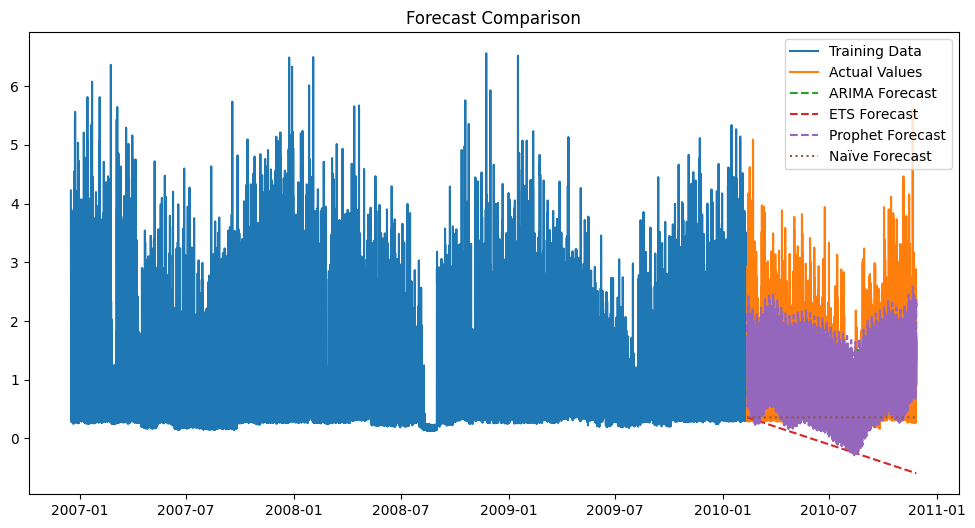

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

print("\nStep 6: Multiple Models and Comparison")

# --- Prepare training and validation sets ---
train_size = int(len(y) * 0.8)
train_data, val_data = y[:train_size], y[train_size:]

results = {}

# --- 1. Baseline (Naïve forecast = last observed value) ---
naive_forecast = pd.Series([train_data.iloc[-1]] * len(val_data), index=val_data.index)

rmse = np.sqrt(mean_squared_error(val_data, naive_forecast))
mae = mean_absolute_error(val_data, naive_forecast)
mape = np.mean(np.abs((val_data - naive_forecast) / val_data)) * 100
results["Naïve"] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# --- 2. ARIMA ---
arima_model = ARIMA(train_data, order=(1,1,1))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(val_data))
arima_pred.index = val_data.index

rmse = np.sqrt(mean_squared_error(val_data, arima_pred))
mae = mean_absolute_error(val_data, arima_pred)
mape = np.mean(np.abs((val_data - arima_pred) / val_data)) * 100
results["ARIMA(1,1,1)"] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# --- 3. Exponential Smoothing (Holt-Winters) ---
ets_model = ExponentialSmoothing(train_data, trend="add", seasonal=None)
ets_fit = ets_model.fit()
ets_pred = ets_fit.forecast(steps=len(val_data))

rmse = np.sqrt(mean_squared_error(val_data, ets_pred))
mae = mean_absolute_error(val_data, ets_pred)
mape = np.mean(np.abs((val_data - ets_pred) / val_data)) * 100
results["ETS"] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# --- 4. Prophet ---
prophet_df = train_data.reset_index()
prophet_df.columns = ["ds", "y"]   

prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_df)

# Future dataframe (validation period)
future = val_data.reset_index()        
future = future.rename(columns={"datetime": "ds"})   

prophet_forecast = prophet.predict(future)

prophet_pred = prophet_forecast["yhat"].values
prophet_pred = pd.Series(prophet_pred, index=val_data.index)

rmse = np.sqrt(mean_squared_error(val_data, prophet_pred))
mae = mean_absolute_error(val_data, prophet_pred)
mape = np.mean(np.abs((val_data - prophet_pred) / val_data)) * 100
results["Prophet"] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}


# --- Compare Results ---
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# --- Visualization ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train_data, label="Training Data")
plt.plot(val_data, label="Actual Values")
plt.plot(arima_pred, label="ARIMA Forecast", linestyle="--")
plt.plot(ets_pred, label="ETS Forecast", linestyle="--")
plt.plot(prophet_pred, label="Prophet Forecast", linestyle="--")
plt.plot(naive_forecast, label="Naïve Forecast", linestyle=":")
plt.legend()
plt.title("Forecast Comparison")
plt.show()


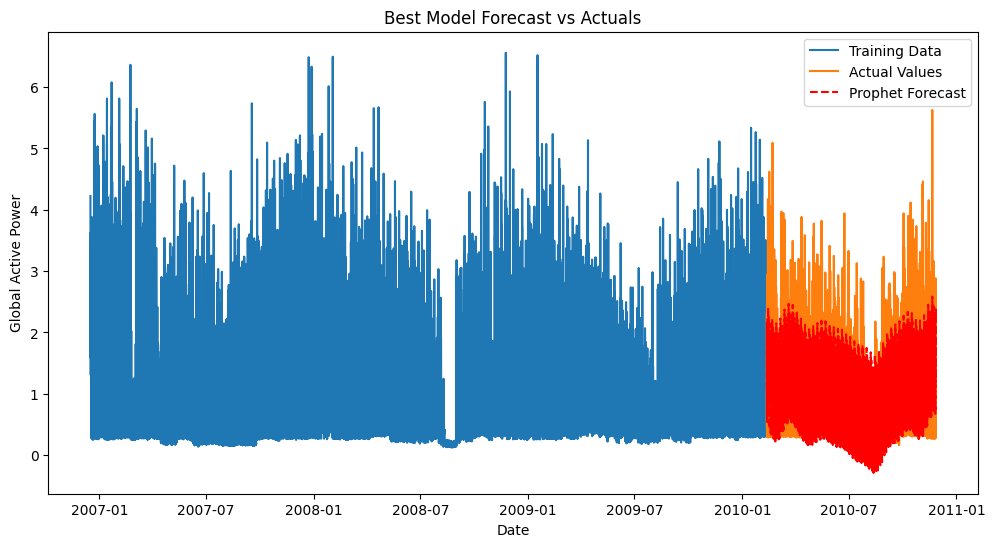

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_data, label="Training Data")
plt.plot(val_data, label="Actual Values")
plt.plot(prophet_pred, label="Prophet Forecast", linestyle="--", color="red")
plt.title("Best Model Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


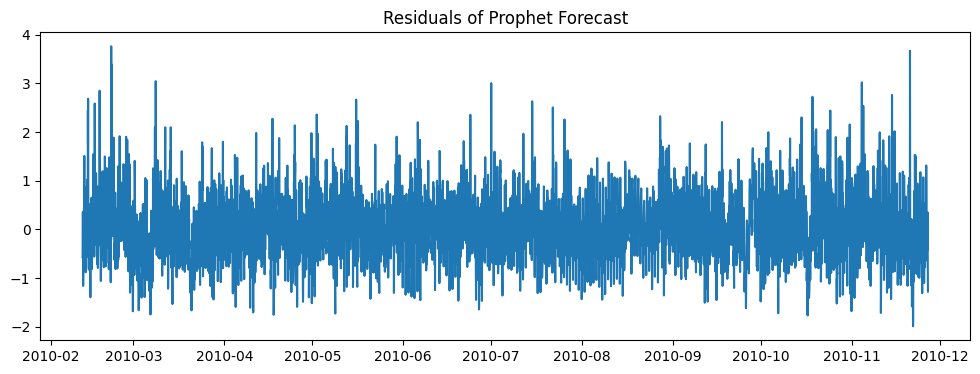

count    6918.000000
mean       -0.005441
std         0.638868
min        -1.993109
25%        -0.425354
50%        -0.037815
75%         0.371874
max         3.760845
dtype: float64


In [85]:
residuals = val_data - prophet_pred
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals of Prophet Forecast")
plt.show()
print(residuals.describe())


--- Residual Diagnostics ---

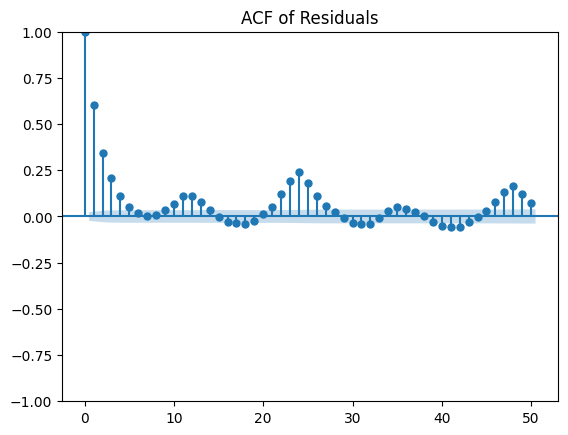

In [86]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()
